# Summary of notebook

This notebook is made up of the following sections
1. Data Ingest
2. Data Wrangling
3. Data Exploration 
4. Modelling 


In [1]:
# Load relevant libaries 
import pandas            as pd
import pandasql          as psql
import requests
from bs4                 import BeautifulSoup
import io
import matplotlib.pyplot as plt

## Data Ingest 

Ingesting this data presents a unique challenge because it is dynamically uploaded via JavaScript, making standard web scraping methods ineffective. Consequently, three specialised functions have been wrote to handle the ingestion. 

Note: The scale of the data is 31 million rows and as such loading times can be extensive. Similar results can be found using a smaller subset. Functions have docstrings; please consult them for additional information.

In [2]:
def extract_csv_urls(url):
    """
    Function to extract CSV URLs from a webpage.

    Args:
    url (str): The URL of the webpage to scrape.

    Returns:
    list: A list of URLs pointing to CSV files found on the webpage.

    """
    csv_urls = []
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    for c in soup.select('contents key'):
        if c.text.startswith('usage-stats') and c.text.endswith('.csv'):
            if '2021' in c.text or '2022' in c.text or '2023' in c.text:
                csv_urls.append('https://cycling.data.tfl.gov.uk/' + c.text)
    return csv_urls

def read_csv_as_dataframe(csv_url):
    """
    Function to read a CSV file from a URL and return it as a DataFrame.

    Args:
    csv_url (str): The URL of the CSV file to read.

    Returns:
    pandas.DataFrame or None: A DataFrame containing the CSV data if successful, otherwise None.

    """
    response = requests.get(csv_url)
    # Check if the request was successful
    if response.status_code == 200:
        # Read CSV content into a DataFrame
        df = pd.read_csv(io.BytesIO(response.content))
        return df
    else:
        print("Failed to fetch CSV from URL:", csv_url)
        return None

def combine_csvs(csv_urls):
    """
    Function to combine multiple CSVs into a single DataFrame.

    Args:
    csv_urls (list): A list of URLs pointing to CSV files.

    Returns:
    pandas.DataFrame: A DataFrame containing the combined data from all CSV files.

    """
    dataframes = []
    for url in csv_urls:
        data = read_csv_as_dataframe(url)
        if data is not None:
            dataframes.append(data)
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


In [3]:
# Ingest Data 
webpage_url = 'https://s3-eu-west-1.amazonaws.com/cycling.data.tfl.gov.uk/?list-type=2&max-keys=1500'
csv_urls = extract_csv_urls(webpage_url)

# If Statement to highlight if the functions have been unsuccessful
if csv_urls:
    data = combine_csvs(csv_urls)
    print("Combined DataFrame from all CSV files:")
else:
    print("No CSV URLs found.")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
/var/folders/ng/895cc__n5t14dstxldbl4nnc0000gn/T/ipykernel_18006/350099696.py:35: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(response.content))
/var/folders/ng/895cc__n5t14dstxldbl4nnc0000gn/T/ipykernel_18006/350099696.py:35: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(response.content

Combined DataFrame from all CSV files:


## Data Wrangling

This section includes 
1. Viewing the data 
2. Visualise Nulls 
3. Identify and fix Null introduction 
4. Cast data types correctly 
5. Check all dates are within 2021-2023 

In [5]:
# Subsetting data to a random 1 million rows for run times
subset_data = data.sample(n=1000000, random_state=42) 

# Quick view shows data appears to have nulls
subset_data.head(10)

# Count nulls by columns. No clear pattern nulls across multiple columns. 
for column in subset_data.columns:
    null_count = subset_data[column].isnull().sum()
    print(f"Column {column}: {null_count} null values")
    
# Find Min/Max Start Date vs Start_Date. 

# Results show that nulls are the result of changing column names on date 2022-09-19. 
# Columns can be mapped together to create a full data set.

# Some column names share similar naming conventions. A postfix has been added to distinguish them.
postfix = '_2019'

# Identify columns 10-20 by their positional indices as the columns to be postfixed
cols_to_postfix = subset_data.columns[9:20]

# Apply the postfix to the selected column names
new_columns = [col + postfix if col in cols_to_postfix else col for col in subset_data.columns]

# Assign the new column names back to the DataFrame
subset_data.columns = new_columns

# SQL interface used to create a unified data frame without nulls. 
# TODO: Need to cast data types. 
# TODO: Check the station ids is this ok.

query = """
SELECT  
    CASE 
        WHEN "Rental Id" IS NULL THEN CAST("Number_2019" AS VARCHAR)
        ELSE CAST("Rental Id" AS VARCHAR)
    END AS "ID",
    CASE 
        WHEN "Duration" IS NULL 
        THEN "Total duration (ms)_2019"/1000 
        ELSE "Duration" 
    END AS Ride_Duration_Seconds,
    CASE WHEN "Bike ID" IS NULL 
        THEN "Bike number_2019" 
        ELSE "Bike ID" 
    END AS Bike_ID, 
    CASE 
        WHEN "Start Date" IS NULL 
        THEN "Start date_2019" 
        ELSE "Start Date" 
    END AS Start_Date, 
    CASE 
        WHEN "End Date" IS NULL 
        THEN "End date_2019" 
        ELSE "End Date"
    END AS End_Date,
    CASE 
        WHEN "StartStation Name" IS NULL 
        THEN "Start station_2019" 
        ELSE "StartStation Name" 
    END AS Start_Station_Name, 
    CASE 
        WHEN "EndStation Name" IS NULL 
        THEN "End station_2019" 
        ELSE "EndStation Name"
    END AS End_Station_Name,
    CASE 
        WHEN "StartStation Id" IS NULL 
        THEN "Start station number_2019" 
        ELSE "StartStation Id" 
    END AS Start_Station_ID, 
    CASE 
        WHEN "EndStation Id" IS NULL 
        THEN "End station number_2019" 
        ELSE "EndStation Id"
    END AS End_Station_ID
FROM subset_data
"""

# Query run
complete_data = psql.sqldf(query, locals())

# Rerun null count 
# Count nulls by columns. No clear pattern nulls across multiple columns. 
for column in complete_data.columns:
    null_count = complete_data[column].isnull().sum()
    print(f"Column {column}: {null_count} null values")

Column Rental Id: 360200 null values
Column Duration: 360200 null values
Column Bike Id: 360200 null values
Column End Date: 360200 null values
Column EndStation Id: 370378 null values
Column EndStation Name: 360200 null values
Column Start Date: 360200 null values
Column StartStation Id: 360200 null values
Column StartStation Name: 360200 null values
Column Number: 639800 null values
Column Start date: 639800 null values
Column Start station number: 639800 null values
Column Start station: 639800 null values
Column End date: 639800 null values
Column End station number: 639800 null values
Column End station: 639800 null values
Column Bike number: 639800 null values
Column Bike model: 639800 null values
Column Total duration: 639800 null values
Column Total duration (ms): 639800 null values
Column ID: 0 null values
Column Ride_Duration_Seconds: 0 null values
Column Bike_ID: 0 null values
Column Start_Date: 0 null values
Column End_Date: 0 null values
Column Start_Station_Name: 0 null v

# Data Exploration 

That data frame has now been wrangled to an appropriate level. 

The analysis is segmented into the three primary areas of interest highlighted by the customer:
1. Usage patterns
2. Customer profiles
3. Operational considerations


### Usage 

In [6]:
# SQL query to extract avg ride duration and total rides per year
query = """
SELECT  
    CASE 
        WHEN "End_Date" LIKE '%2021%' THEN '2021'
        WHEN "End_Date" LIKE '%2022%' THEN '2022'
        WHEN "End_Date" LIKE '%2023%' THEN '2023'
        ELSE 'Other'
    END AS Year,
    AVG(Ride_Duration_Seconds) AS Average_Ride_Duration,
    COUNT(*) as Total_Rides
FROM complete_data
WHERE Year NOT LIKE 'Other'
GROUP BY 
    CASE 
        WHEN "End_Date" LIKE '%2021%' THEN '2021'
        WHEN "End_Date" LIKE '%2022%' THEN '2022'
        WHEN "End_Date" LIKE '%2023%' THEN '2023'
        ELSE 'Other'
    END
"""

# Run query and save to df
usage_date = psql.sqldf(query, locals())

# Calculate the YoY growth for both key metrics
usage_date['YoY_Growth_Duration'] = usage_date['Average_Ride_Duration'].pct_change() * 100
usage_date['YoY_Growth_Rides'] = usage_date['Total_Rides'].pct_change() * 100

# Add 'type' column. Needed for plotting actuals vs predicted.
usage_date['type'] = 'actual'

# Calculate average YoY growth over all years.
average_yoy_growth_duration = usage_date['YoY_Growth_Duration'].mean()
average_yoy_growth_rides = usage_date['YoY_Growth_Rides'].mean()

# Predict Average_Ride_Duration for 2024 using 2023 metrics * average YoY growth metric
predicted_2024_duration = usage_date.loc[usage_date['Year'] == '2023', 'Average_Ride_Duration'].values[0] * (1 + average_yoy_growth_duration / 100)
predicted_2024_rides = usage_date.loc[usage_date['Year'] == '2023', 'Total_Rides'].values[0] * (1 + average_yoy_growth_rides / 100)

# Create the 2024 Row using previous calculations
new_row = {
    'Year': '2024',
    'Average_Ride_Duration': predicted_2024_duration,
    'Total_Rides': predicted_2024_rides,
    'type': 'predicted'
}

# Append 2024 to existing dataframe and add avg yoy growth metrics.
usage_data_metrics = pd.concat([usage_date, pd.DataFrame([new_row])], ignore_index=True)
usage_data_metrics['avg_yearly_yoy_growth_duration'] = average_yoy_growth_duration
usage_data_metrics['average_yoy_growth_rides'] = average_yoy_growth_rides
usage_data_metrics.head(4)

,Year,Average_Ride_Duration,Total_Rides,YoY_Growth_Duration,YoY_Growth_Rides,type,avg_yearly_yoy_growth_duration,average_yoy_growth_rides
0,2021,1310.254390,350761.000000,NaN,NaN,actual,11.298209,-9.778601
1,2022,1273.949189,371279.000000,-2.770851,5.849567,actual,11.298209,-9.778601
2,2023,1597.115301,276949.000000,25.367269,-25.406770,actual,11.298209,-9.778601
3,2024,1777.560720,249867.261641,NaN,NaN,predicted,11.298209,-9.778601


#### Usage Visualisation

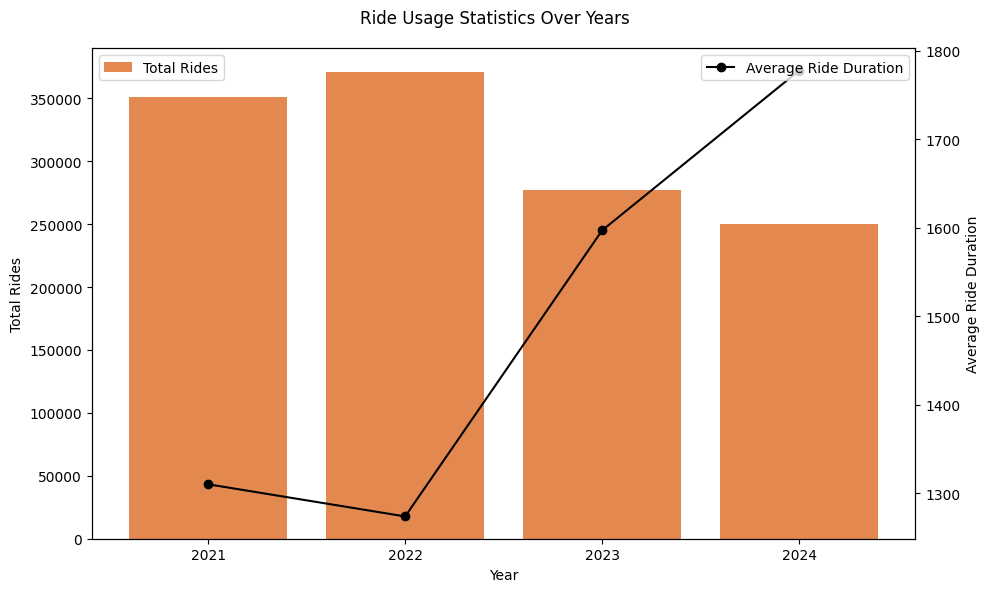

In [7]:
# Creating the figure and axes objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting Total Rides on the first y-axis
ax1.bar(usage_data_metrics['Year'], usage_data_metrics['Total_Rides'], color='#D85604', alpha=0.7, label='Total Rides')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Rides')
ax1.tick_params('y')

# Creating a second y-axis for Average Ride Duration
ax2 = ax1.twinx()
ax2.plot(usage_data_metrics['Year'], usage_data_metrics['Average_Ride_Duration'], color='black', marker='o', label='Average Ride Duration')
ax2.set_ylabel('Average Ride Duration', color='black')
ax2.tick_params('y', colors='black')

# Adding title and legend
fig.suptitle('Ride Usage Statistics Over Years')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

### Customer Profiles - Time 

In [8]:
# SQL query to extract count of rides at hourly aggregate grouped by whether weekend 

query = """
WITH dates AS (
    SELECT 
        SUBSTRING(Start_Date, 1, 10) AS date,
        SUBSTR(Start_Date, 12, 2) AS hour,
        *
    FROM 
        complete_data
) 

SELECT
    *,
    CASE 
        WHEN INSTR(date, '-') > 0 THEN DATE(date) -- Format: yyyy-mm-dd
        WHEN INSTR(date, '/') > 0 AND LENGTH(date) = 10 THEN DATE(SUBSTR(date, 7, 4) || '-' || SUBSTR(date, 4, 2) || '-' || SUBSTR(date, 1, 2)) -- Format: mm/dd/yyyy
        WHEN INSTR(date, '/') > 0 AND LENGTH(date) = 8 THEN DATE(SUBSTR(date, 5, 4) || '-' || SUBSTR(date, 3, 2) || '-' || SUBSTR(date, 1, 2)) -- Format: dd/mm/yyyy
        ELSE NULL 
    END AS normalised_date
FROM dates 
"""

# Run query and save to df
time_data  = psql.sqldf(query, locals())

In [10]:
# Weekend Flag 
time_data_cleaned = pd.DataFrame(time_data)
time_data_cleaned['normalised_date'] = pd.to_datetime(time_data['normalised_date'])
time_data_cleaned['is_weekend'] = time_data_cleaned['normalised_date'].dt.dayofweek // 5

# Count number of TODO
time_data_metrics = time_data_cleaned.groupby(['hour', 'is_weekend']).size().reset_index(name='count')
time_data_metrics['hour'] = pd.to_numeric(time_data_metrics['hour'])

# Function to normalise the count within each group
def min_max_normalise(group):
    return (group - group.min()) / (group.max() - group.min())

# Apply the normalisation within each group
time_data_metrics['count_normalised'] = time_data_metrics.groupby('is_weekend')['count'].transform(min_max_normalise)



#### Customer Profiles - Time Visualisation

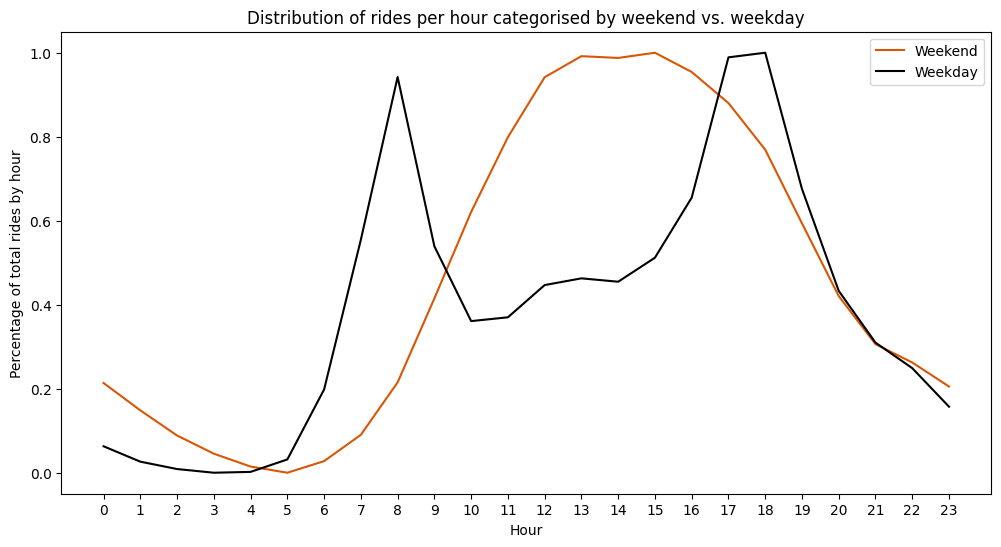

In [11]:
# Define colours
color1 = '#D85604'  
color2 = '#000000'  

# Filter the data into weekend and weekday subsets
weekend_data = time_data_metrics[time_data_metrics['is_weekend'] == True]
weekday_data = time_data_metrics[time_data_metrics['is_weekend'] == False]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot weekend line
line_weekend, = ax.plot(weekend_data['hour'], weekend_data['count_normalised'], color=color1, label='Weekend')

# Plot weekday line
line_weekday, = ax.plot(weekday_data['hour'], weekday_data['count_normalised'], color=color2, label='Weekday')

# Adding labels and title
ax.set_xlabel('Hour')
ax.set_ylabel('Percentage of total rides by hour')
ax.set_title('Distribution of rides per hour categorised by weekend vs. weekday')

# Set x-ticks to show all hours
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))

# Adding legend
ax.legend()

# Show plot
plt.show()

## Reliability

In [13]:
# SQL query to extract count of rides at hourly aggregate grouped by whether weekend 

reliability_query = """
WITH dates AS (
    SELECT 
        *,
        SUBSTR(Start_Date, 1, 10) AS date
    FROM 
        complete_data
) 
SELECT
    Bike_Id AS bike_id,
    MIN(date) AS first_use, 
    MAX(date) AS last_use,
    julianday(MAX(date)) - julianday(MIN(date)) AS date_difference
FROM dates
GROUP BY ID
"""

# Run query and save to df
reliability_data  = psql.sqldf(reliability_query, locals())

In [14]:
reliability_data

,bike_id,first_use,last_use,date_difference
0,18107.0,30/12/2020,30/12/2020,NaN
1,3403.0,30/12/2020,30/12/2020,NaN
2,19006.0,30/12/2020,30/12/2020,NaN
3,15785.0,30/12/2020,30/12/2020,NaN
4,12122.0,30/12/2020,30/12/2020,NaN
...,...,...,...,...
999995,56277.0,2023-12-31,2023-12-31,0.0
999996,57698.0,2023-12-31,2023-12-31,0.0
999997,57440.0,2023-12-31,2023-12-31,0.0
999998,59565.0,2023-12-31,2023-12-31,0.0


In [ ]:
# TODO: Reliability still isn't correct fix that. More usage = likely to break 
# TODO: EDA Complete 
# TODO: Clean Slides 
# TODO: Data Science Use Case - Supply Chain Bike Optimisation bikes where they need to be (Time series forecast of demand, features) 
#                             - Cluster Customer types inform dynamic pricing & marketing (Features, Start_Date, Location, Duration)
# TODO: Build TS Forecast day level with features () - Future development, hourly level to meet peak & discern between week and weekend, add reliability prediction.                           
# TODO: Recomendations 